## **0. Tải bộ dữ liệu**
**Lưu ý:** Nếu không thể tải bằng gdown do bị giới hạn số lượt tải, các bạn hãy tải thủ công và đưa lên drive của mình, sau đó copy từ drive vào colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1WNju5xpuQFnjofglX1hqBXZXF8x8cb3S/view?usp=drive_link
# https://drive.google.com/file/d/1ixKFaCf6eE2rChysTTb9M2L6p0ahe4nK/view?usp=drive_link
# https://drive.google.com/file/d/1wOwzcH74xHZJEMQMcia3qYEkCwsaBQhU/view?usp=drive_link
# https://drive.google.com/file/d/1JmIJOgJaqcnuRuXtA0bCaFhRscRSYjNe/view?usp=drive_link
!gdown --id 1WNju5xpuQFnjofglX1hqBXZXF8x8cb3S
!gdown --id 1ixKFaCf6eE2rChysTTb9M2L6p0ahe4nK
!gdown --id 1wOwzcH74xHZJEMQMcia3qYEkCwsaBQhU
!gdown --id 1JmIJOgJaqcnuRuXtA0bCaFhRscRSYjNe

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WNju5xpuQFnjofglX1hqBXZXF8x8cb3S
To: /content/PNJ.csv
100% 6.25M/6.25M [00:00<00:00, 34.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ixKFaCf6eE2rChysTTb9M2L6p0ahe4nK
To: /content/FPT.csv
100% 4.87M/4.87M [00:00<00:00, 27.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google

## **1. Import các thư viện cần thiết**

In [2]:
import os
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

## **2. Trực quan hóa dữ liệu**

In [3]:
filepath = './MSN.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
msn = pd.read_csv(filepath) # Đọc file .csv thành DataFrame
msn['Date/Time'] = pd.to_datetime(msn['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
msn_hour = msn[msn['Date/Time'].dt.time != datetime.strptime('14:46:00', '%H:%M:%S').time()]
msn_hour.index = pd.to_datetime(msn_hour['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
msn_hour = msn_hour.drop(['Date/Time', 'Ticker', 'Open Interest'], axis=1) # Loại bỏ trường Ticker, Date/Time, Open Interest
msn_hour = msn_hour.resample('60min').mean()
msn = msn_hour.dropna()
msn = msn.rename({'Open': 'MSN_Open', 'High': 'MSN_High', 'Low': 'MSN_Low', 'Close': 'MSN_Close', 'Volume': 'MSN_Volume'}, axis='columns')
msn

,MSN_Open,MSN_High,MSN_Low,MSN_Close,MSN_Volume
Date/Time,,,,,
2017-12-25 09:00:00,73.191304,73.226087,73.178261,73.200000,2016.956522
2017-12-25 10:00:00,73.583333,73.600000,73.583333,73.600000,1705.333333
2017-12-25 11:00:00,73.800000,73.800000,73.783333,73.783333,2300.000000
2017-12-25 13:00:00,73.751724,73.751724,73.724138,73.724138,815.862069
2017-12-25 14:00:00,74.636842,74.636842,74.636842,74.636842,2123.157895
...,...,...,...,...,...
2020-12-22 09:00:00,83.465116,83.525581,83.381395,83.430233,5368.837209
2020-12-22 10:00:00,83.350000,83.366667,83.329630,83.350000,1960.555556
2020-12-22 11:00:00,83.075862,83.086207,83.048276,83.058621,5269.310345


In [4]:
filepath = './FPT.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
fpt = pd.read_csv(filepath) # Đọc file .csv thành DataFrame
fpt['Date/Time'] = pd.to_datetime(fpt['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
fpt_hour = fpt[fpt['Date/Time'].dt.time != datetime.strptime('14:46:00', '%H:%M:%S').time()]
fpt_hour.index = pd.to_datetime(fpt_hour['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
fpt_hour = fpt_hour.drop(['Date/Time', 'Ticker', 'Open Interest'], axis=1) # Loại bỏ trường Ticker, Date/Time, Open Interest
fpt_hour = fpt_hour.resample('60min').mean()
fpt = fpt_hour.dropna()
fpt = fpt.rename({'Open': 'FPT_Open', 'High': 'FPT_High', 'Low': 'FPT_Low', 'Close': 'FPT_Close', 'Volume': 'FPT_Volume'}, axis='columns')
fpt

,FPT_Open,FPT_High,FPT_Low,FPT_Close,FPT_Volume
Date/Time,,,,,
2018-12-25 09:00:00,30.760000,30.781429,30.744286,30.760000,12137.142857
2018-12-26 09:00:00,31.055714,31.065357,31.047500,31.057143,1783.928571
2018-12-26 10:00:00,31.121842,31.125789,31.116579,31.121579,2508.684211
2018-12-26 11:00:00,31.036875,31.046250,31.034375,31.046250,2331.250000
2018-12-26 13:00:00,30.993200,31.002800,30.993200,31.002800,2451.200000
...,...,...,...,...,...
2020-12-22 09:00:00,57.468889,57.486667,57.440000,57.453333,7560.888889
2020-12-22 10:00:00,57.393333,57.413333,57.368333,57.393333,5966.833333
2020-12-22 11:00:00,57.507143,57.532143,57.471429,57.507143,12836.428571


In [5]:
filepath = './PNJ.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
pnj = pd.read_csv(filepath) # Đọc file .csv thành DataFrame
pnj['Date/Time'] = pd.to_datetime(pnj['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
pnj_hour = pnj[pnj['Date/Time'].dt.time != datetime.strptime('14:46:00', '%H:%M:%S').time()]
pnj_hour.index = pd.to_datetime(pnj_hour['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
pnj_hour = pnj_hour.drop(['Date/Time', 'Ticker', 'Open Interest'], axis=1) # Loại bỏ trường Ticker, Date/Time, Open Interest
pnj_hour = pnj_hour.resample('60min').mean()
pnj = pnj_hour.dropna()
pnj = pnj.rename({'Open': 'PNJ_Open', 'High': 'PNJ_High', 'Low': 'PNJ_Low', 'Close': 'PNJ_Close', 'Volume': 'PNJ_Volume'}, axis='columns')
pnj

,PNJ_Open,PNJ_High,PNJ_Low,PNJ_Close,PNJ_Volume
Date/Time,,,,,
2018-02-28 09:00:00,78.755946,78.886216,78.615135,78.705946,106.297297
2018-02-28 10:00:00,78.657750,78.716000,78.629250,78.693500,75.925000
2018-02-28 11:00:00,78.795000,78.806875,78.789375,78.801250,74.250000
2018-03-01 09:00:00,78.534333,78.561333,78.505000,78.550667,102.833333
2018-03-01 10:00:00,78.901579,78.956842,78.840000,78.895263,108.710526
...,...,...,...,...,...
2020-12-22 09:00:00,77.507143,77.542857,77.471429,77.526190,6836.666667
2020-12-22 10:00:00,78.203636,78.249091,78.172727,78.220000,7462.727273
2020-12-22 11:00:00,78.041379,78.058621,78.034483,78.048276,1590.689655


In [6]:
filepath = './VIC.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
vic = pd.read_csv(filepath) # Đọc file .csv thành DataFrame
vic['Date/Time'] = pd.to_datetime(vic['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
vic_hour = vic[vic['Date/Time'].dt.time != datetime.strptime('14:46:00', '%H:%M:%S').time()]
vic_hour.index = pd.to_datetime(vic_hour['Date/Time'], format='%m/%d/%Y %H:%M') # Chuyển trường Data/Time sang định dạng Datetime
vic_hour = vic_hour.drop(['Date/Time', 'Ticker', 'Open Interest'], axis=1) # Loại bỏ trường Ticker, Date/Time, Open Interest
vic_hour = vic_hour.resample('60min').mean()
vic = vic_hour.dropna()
vic = vic.rename({'Open': 'VIC_Open', 'High': 'VIC_High', 'Low': 'VIC_Low', 'Close': 'VIC_Close', 'Volume': 'VIC_Volume'}, axis='columns')
vic

,VIC_Open,VIC_High,VIC_Low,VIC_Close,VIC_Volume
Date/Time,,,,,
2018-10-17 09:00:00,98.642105,98.689474,98.626316,98.668421,6384.736842
2018-10-17 10:00:00,98.872000,98.906000,98.820000,98.848000,5230.200000
2018-10-17 11:00:00,98.534615,98.580769,98.507692,98.553846,6928.461538
2018-10-17 13:00:00,98.550000,98.578261,98.521739,98.547826,5132.391304
2018-10-17 14:00:00,98.480769,98.503846,98.473077,98.488462,10160.000000
...,...,...,...,...,...
2020-12-22 09:00:00,106.388095,106.440476,106.311905,106.354762,5457.619048
2020-12-22 10:00:00,106.210345,106.244828,106.144828,106.179310,1448.620690
2020-12-22 11:00:00,106.051852,106.085185,105.948148,105.996296,2810.740741


In [7]:
df = pd.concat([msn, fpt, pnj, vic], axis=1)
df = df.bfill()
df

,MSN_Open,MSN_High,MSN_Low,MSN_Close,MSN_Volume,FPT_Open,FPT_High,FPT_Low,FPT_Close,FPT_Volume,PNJ_Open,PNJ_High,PNJ_Low,PNJ_Close,PNJ_Volume,VIC_Open,VIC_High,VIC_Low,VIC_Close,VIC_Volume
Date/Time,,,,,,,,,,,,,,,,,,,,
2017-12-25 09:00:00,73.191304,73.226087,73.178261,73.200000,2016.956522,30.760000,30.781429,30.744286,30.760000,12137.142857,78.755946,78.886216,78.615135,78.705946,106.297297,98.642105,98.689474,98.626316,98.668421,6384.736842
2017-12-25 10:00:00,73.583333,73.600000,73.583333,73.600000,1705.333333,30.760000,30.781429,30.744286,30.760000,12137.142857,78.755946,78.886216,78.615135,78.705946,106.297297,98.642105,98.689474,98.626316,98.668421,6384.736842
2017-12-25 11:00:00,73.800000,73.800000,73.783333,73.783333,2300.000000,30.760000,30.781429,30.744286,30.760000,12137.142857,78.755946,78.886216,78.615135,78.705946,106.297297,98.642105,98.689474,98.626316,98.668421,6384.736842
2017-12-25 13:00:00,73.751724,73.751724,73.724138,73.724138,815.862069,30.760000,30.781429,30.744286,30.760000,12137.142857,78.755946,78.886216,78.615135,78.705946,106.297297,98.642105,98.689474,98.626316,98.668421,6384.736842
2017-12-25 14:00:00,74.636842,74.636842,74.636842,74.636842,2123.157895,30.760000,30.781429,30.744286,30.760000,12137.142857,78.755946,78.886216,78.615135,78.705946,106.297297,98.642105,98.689474,98.626316,98.668421,6384.736842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 09:00:00,83.465116,83.525581,83.381395,83.430233,5368.837209,57.468889,57.486667,57.440000,57.453333,7560.888889,77.507143,77.542857,77.471429,77.526190,6836.666667,106.388095,106.440476,106.311905,106.354762,5457.619048
2020-12-22 10:00:00,83.350000,83.366667,83.329630,83.350000,1960.555556,57.393333,57.413333,57.368333,57.393333,5966.833333,78.203636,78.249091,78.172727,78.220000,7462.727273,106.210345,106.244828,106.144828,106.179310,1448.620690
2020-12-22 11:00:00,83.075862,83.086207,83.048276,83.058621,5269.310345,57.507143,57.532143,57.471429,57.507143,12836.428571,78.041379,78.058621,78.034483,78.048276,1590.689655,106.051852,106.085185,105.948148,105.996296,2810.740741


In [8]:
df.describe()

,MSN_Open,MSN_High,MSN_Low,MSN_Close,MSN_Volume,FPT_Open,FPT_High,FPT_Low,FPT_Close,FPT_Volume,PNJ_Open,PNJ_High,PNJ_Low,PNJ_Close,PNJ_Volume,VIC_Open,VIC_High,VIC_Low,VIC_Close,VIC_Volume
count,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000,3733.000000
mean,76.221525,76.270777,76.179625,76.223595,4499.217758,39.840031,39.858790,39.822040,39.839966,8809.590506,72.748952,72.930046,72.613044,72.744144,2496.168408,104.007341,104.050332,103.973004,104.016624,3555.813459
std,14.854118,14.861212,14.849769,14.854823,4497.963046,8.453832,8.455545,8.449170,8.453757,5513.086322,9.510532,9.591220,9.453615,9.508078,2268.530092,10.321608,10.314742,10.325594,10.319851,2505.237400
min,46.506250,46.511607,46.500000,46.506250,70.000000,30.316757,30.319730,30.309459,30.314324,546.190476,45.719483,45.859138,45.582069,45.692241,11.933333,71.360000,71.522222,71.220000,71.415556,105.714286
25%,61.520000,61.575862,61.470000,61.533898,2051.372549,30.760000,30.781429,30.744286,30.760000,4507.142857,66.692308,66.849600,66.611282,66.701429,1168.055556,98.642105,98.689474,98.626316,98.668421,1455.135135
50%,80.082759,80.134783,80.054386,80.084615,3248.644068,38.267727,38.275000,38.260000,38.270455,8525.892857,73.218085,73.397857,73.118800,73.240000,1982.173913,98.642105,98.689474,98.626316,98.668421,2723.720930
75%,86.723529,86.812281,86.711111,86.722222,5279.285714,48.058333,48.085000,48.043103,48.068889,12137.142857,79.914750,80.157736,79.795769,79.960000,3151.034483,114.831818,114.867797,114.816216,114.841379,6384.736842
max,117.020833,117.041667,117.008333,117.029167,49484.333333,58.189286,58.232143,58.167857,58.192857,76526.444444,97.590385,97.849615,97.343077,97.521538,21165.111111,125.853659,125.880488,125.817073,125.853659,23698.800000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3733 entries, 2017-12-25 09:00:00 to 2020-12-22 14:00:00
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MSN_Open    3733 non-null   float64
 1   MSN_High    3733 non-null   float64
 2   MSN_Low     3733 non-null   float64
 3   MSN_Close   3733 non-null   float64
 4   MSN_Volume  3733 non-null   float64
 5   FPT_Open    3733 non-null   float64
 6   FPT_High    3733 non-null   float64
 7   FPT_Low     3733 non-null   float64
 8   FPT_Close   3733 non-null   float64
 9   FPT_Volume  3733 non-null   float64
 10  PNJ_Open    3733 non-null   float64
 11  PNJ_High    3733 non-null   float64
 12  PNJ_Low     3733 non-null   float64
 13  PNJ_Close   3733 non-null   float64
 14  PNJ_Volume  3733 non-null   float64
 15  VIC_Open    3733 non-null   float64
 16  VIC_High    3733 non-null   float64
 17  VIC_Low     3733 non-null   float64
 18  VIC_Close   3733 non-null   floa

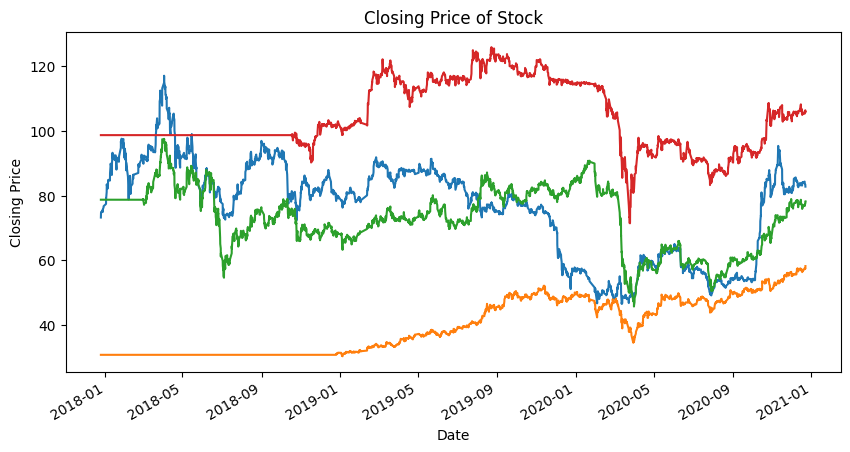

In [10]:
plt.figure(figsize=(10, 5))
df['MSN_Close'].plot()
df['FPT_Close'].plot()
df['PNJ_Close'].plot()
df['VIC_Close'].plot()
plt.title('Closing Price of Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

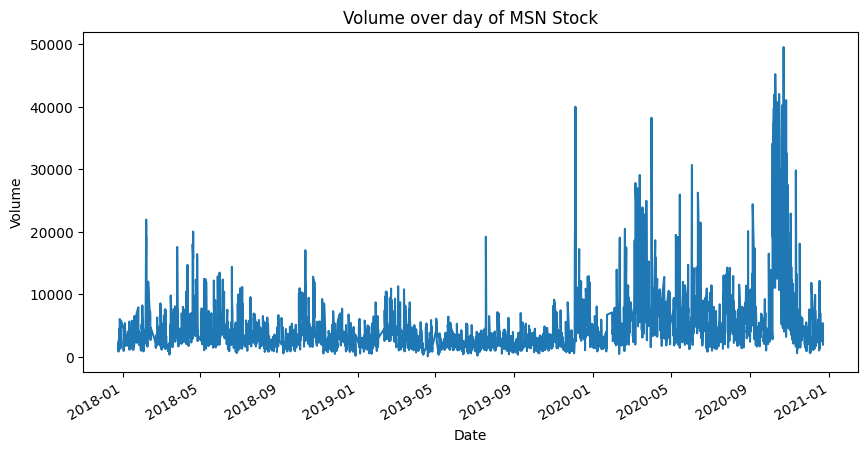

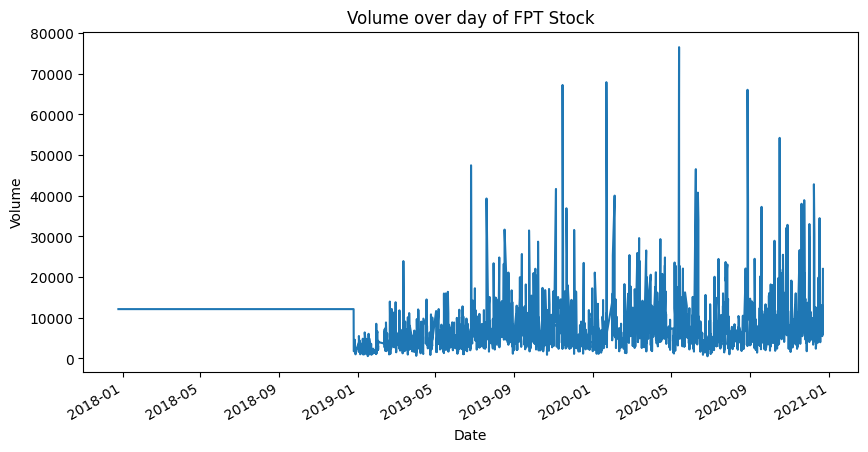

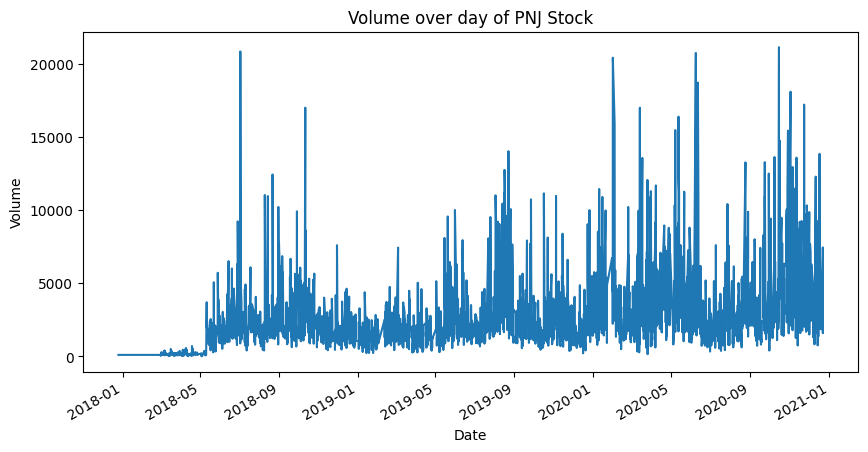

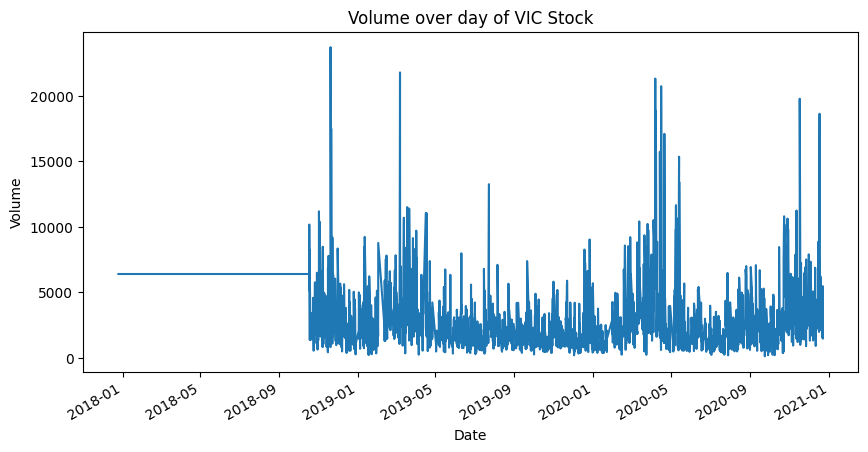

In [11]:
plt.figure(figsize=(10, 5))
df['MSN_Volume'].plot()
plt.title('Volume over day of MSN Stock')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.figure(figsize=(10, 5))
df['FPT_Volume'].plot()
plt.title('Volume over day of FPT Stock')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.figure(figsize=(10, 5))
df['PNJ_Volume'].plot()
plt.title('Volume over day of PNJ Stock')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.figure(figsize=(10, 5))
df['VIC_Volume'].plot()
plt.title('Volume over day of VIC Stock')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.show()

## **3. Chuẩn bị dữ liệu**

In [12]:
# Khai báo hàm Windowing (dùng để tạo các cặp X, y cho time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = [] # Khai báo list dùng để lưu trữ các y

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size
    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx] # Lấy X
        label = df[label_name][label_start_idx:label_end_idx] # Lấy y

        features.append(feature)
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [13]:
def slicing_window_flatten(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = []
    labels = []

    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx].to_numpy().flatten()
        label = df[label_name][label_start_idx:label_end_idx]

        features.append(feature)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [14]:
INPUT_SIZE = 150
LABEL_SIZE = 1
OFFSET = 1
BATCH_SIZE = 64
TARGET_NAME = 'MSN_Close'

In [15]:
dataset_length = len(df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length)
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train_1, y_train_1 = slicing_window(df,
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập val
X_val_1, y_val_1 = slicing_window(df,
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập test
X_test_1, y_test_1 = slicing_window(df,
                                    df_start_idx=VAL_END_IDX,
                                    df_end_idx=None,
                                    input_size=INPUT_SIZE,
                                    label_size=LABEL_SIZE,
                                    offset=OFFSET,
                                    label_name=TARGET_NAME)

In [16]:
dataset_length = len(df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length)
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window_flatten(df,
                                          df_start_idx=0,
                                          df_end_idx=TRAIN_END_IDX,
                                          input_size=INPUT_SIZE,
                                          label_size=LABEL_SIZE,
                                          offset=OFFSET,
                                          label_name=TARGET_NAME)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window_flatten(df,
                                      df_start_idx=TRAIN_END_IDX,
                                      df_end_idx=VAL_END_IDX,
                                      input_size=INPUT_SIZE,
                                      label_size=LABEL_SIZE,
                                      offset=OFFSET,
                                      label_name=TARGET_NAME)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window_flatten(df,
                                        df_start_idx=VAL_END_IDX,
                                        df_end_idx=None,
                                        input_size=INPUT_SIZE,
                                        label_size=LABEL_SIZE,
                                        offset=OFFSET,
                                        label_name=TARGET_NAME)

In [17]:
# Khởi tạo tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train_1, y_train_1)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_1, y_val_1)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_1, y_test_1)).batch(BATCH_SIZE)

In [18]:
# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **4. Mô hình XGBoost**

### **4.1. Xây dựng mô hình**

In [19]:
xgboost = XGBRegressor()

### **4.2. Huấn luyện mô hình**

In [20]:
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### **4.3. Đánh giá và trực quan hóa**

In [21]:
def mae(y_true, y_pred):
    mae = np.mean(np.abs((y_true - y_pred)))

    return mae

def mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)

    return mse

def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))

    return rmse

def mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true-y_pred) / y_true)) * 100

    return mape

In [22]:
y_test_pred = xgboost.predict(X_test)
print(f'RMSE: {rmse(y_test, y_test_pred)}')
print(f'MAPE: {mape(y_test, y_test_pred)}')
print(f'MSE: {mse(y_test, y_test_pred)}')
print(f'MAE: {mae(y_test, y_test_pred)}')

RMSE: 4.639978400640974
MAPE: 3.8579447902820267
MSE: 21.52939955841477
MAE: 3.307749838154574


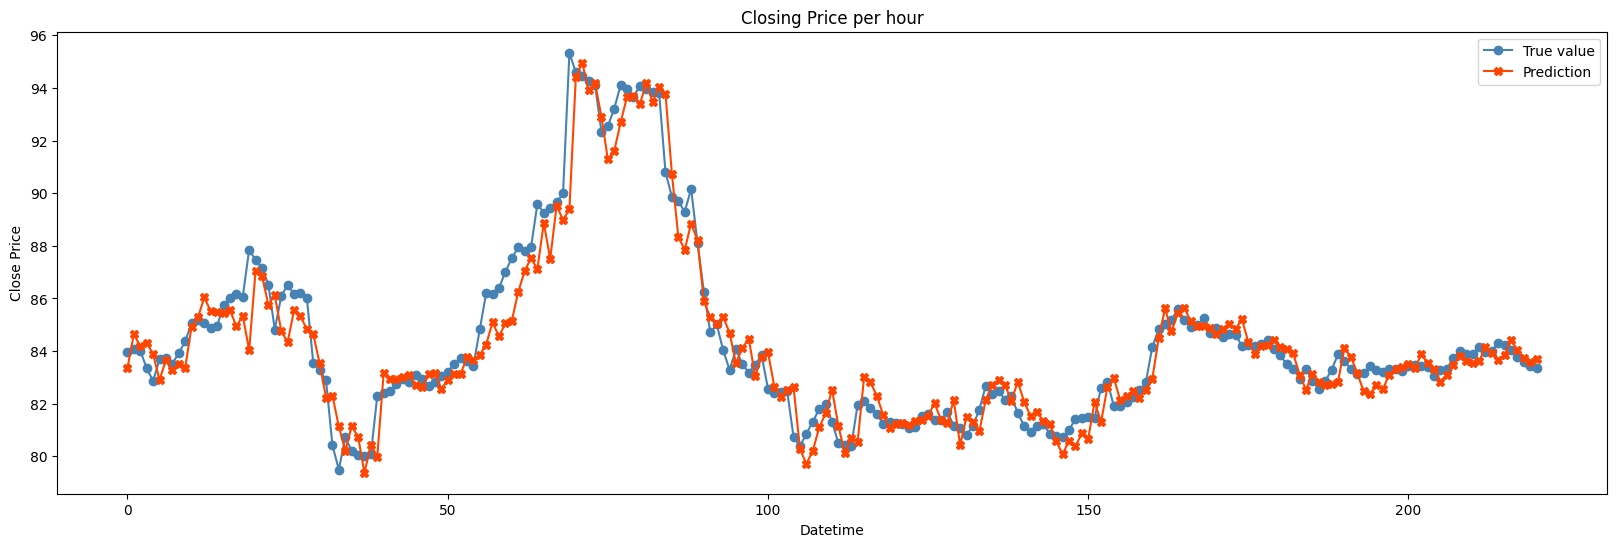

In [23]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test, xgboost.predict(X_test))

## **5. Mô hình Linear Regression**

### **5.1. Xây dựng mô hình**

In [24]:
linear = LinearRegression()

### **5.2. Huấn luyện mô hình**

In [25]:
linear.fit(X_train, y_train)

LinearRegression()

### **5.3. Đánh giá và trực quan hóa**

In [26]:
y_test_pred = linear.predict(X_test)
print(f'RMSE: {rmse(y_test, y_test_pred)}')
print(f'MAPE: {mape(y_test, y_test_pred)}')
print(f'MSE: {mse(y_test, y_test_pred)}')
print(f'MAE: {mae(y_test, y_test_pred)}')

RMSE: 15.976634533974671
MAPE: 17.339629430907856
MSE: 255.25285103219204
MAE: 14.663126984122464


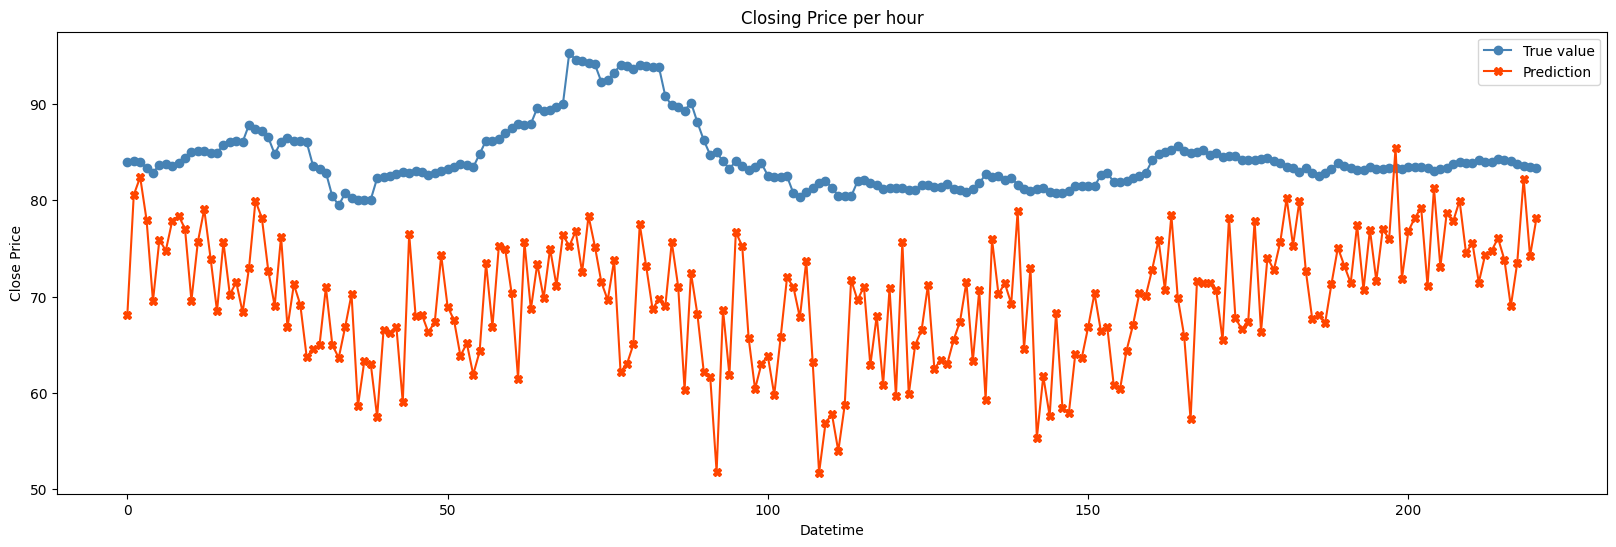

In [27]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test, linear.predict(X_test))

## **6. Mô hình Ridge Regression**

### **6.1. Xây dựng mô hình**

In [28]:
ridge = Ridge(alpha=1.0)

### **6.2. Huấn luyện mô hình**

In [29]:
ridge.fit(X_train, y_train)

Ridge()

In [30]:
y_test_pred = ridge.predict(X_test)
print(f'RMSE: {rmse(y_test, y_test_pred)}')
print(f'MAPE: {mape(y_test, y_test_pred)}')
print(f'MSE: {mse(y_test, y_test_pred)}')
print(f'MAE: {mae(y_test, y_test_pred)}')

RMSE: 2.749534687501728
MAPE: 2.630453432373774
MSE: 7.559940997775227
MAE: 2.2344274885301862


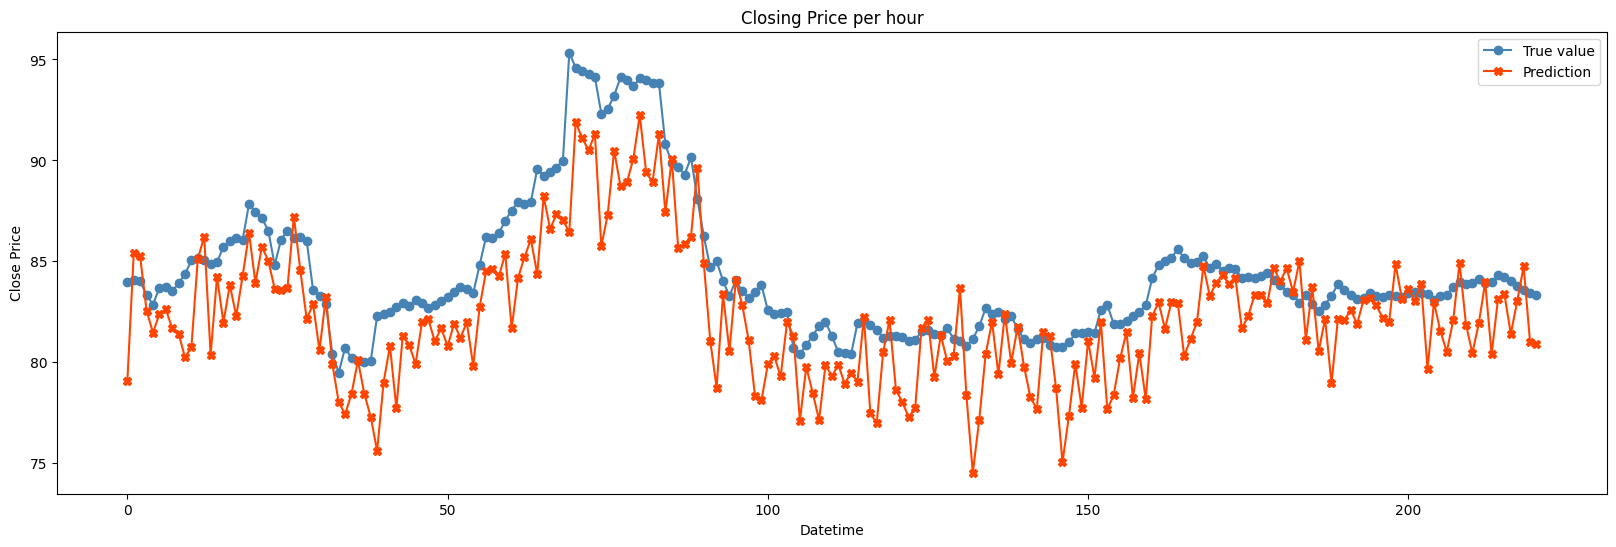

In [31]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test, ridge.predict(X_test))

## **7. Mô hình BiLSTM**

### **7.1. Xây dựng mô hình**

In [32]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization()
normalize_layer.adapt(np.vstack((X_train_1, X_val_1, X_test_1)))

In [33]:
# Xây dựng hàm khởi tạo model
def build_model(input_shape, output_size):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.Input(shape=input_shape, name='input_layer'),

        normalize_layer,

        # BiLSTM Layer 1
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,
                                                           return_sequences=True,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_1'),

        # Dropout Layer 1
        tf.keras.layers.Dropout(0.2, name='dropout_layer_1'),

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                                           return_sequences=True,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_2'),

        # Dropout Layer 2
        tf.keras.layers.Dropout(0.2, name='dropout_layer_2'),

        # BiLSTM Layer 3
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                           return_sequences=False,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_3'),

        # Dropout Layer 3
        tf.keras.layers.Dropout(0.2, name='dropout_layer_3'),

        # FC Layer 1
        tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fc_layer_1'
                              ),

        # Output Layer
        tf.keras.layers.Dense(output_size,
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer')
    ],
    name='bilstm_model')

    return model

In [34]:
INPUT_SHAPE = X_train_1.shape[-2:]
model = build_model(INPUT_SHAPE,
                    LABEL_SIZE)
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 150, 20)           41        
 on)                                                             
                                                                 
 bilstm_layer_1 (Bidirectio  (None, 150, 256)          152576    
 nal)                                                            
                                                                 
 dropout_layer_1 (Dropout)   (None, 150, 256)          0         
                                                                 
 bilstm_layer_2 (Bidirectio  (None, 150, 128)          164352    
 nal)                                                            
                                                                 
 dropout_layer_2 (Dropout)   (None, 150, 128)          0         
                                                      

### **7.2. Cấu hình mô hình**

In [35]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 500
LR = 1e-3

In [36]:
# Cấu hình một số thông tin cho mô hình
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.MeanSquaredError(), # Sử dụng hàm loss Mean Squared Error
)

### **7.3. Huấn luyện mô hình**

In [37]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/500
39/39 [==============================] - 18s 108ms/step - loss: 6388.2651 - val_loss: 3219.0693
Epoch 2/500
39/39 [==============================] - 2s 41ms/step - loss: 4826.0273 - val_loss: 3104.9253
Epoch 3/500
39/39 [==============================] - 1s 38ms/step - loss: 3208.7913 - val_loss: 874.1105
Epoch 4/500
39/39 [==============================] - 1s 37ms/step - loss: 1689.2756 - val_loss: 303.6449
Epoch 5/500
39/39 [==============================] - 1s 38ms/step - loss: 678.8417 - val_loss: 153.0662
Epoch 6/500
39/39 [==============================] - 1s 37ms/step - loss: 263.6184 - val_loss: 210.3647
Epoch 7/500
39/39 [==============================] - 2s 47ms/step - loss: 170.0750 - val_loss: 250.2475
Epoch 8/500
39/39 [==============================] - 1s 38ms/step - loss: 156.8549 - val_loss: 259.3373
Epoch 9/500
39/39 [==============================] - 1s 38ms/step - loss: 153.4216 - val_loss: 257.8857
Epoch 10/500
39/39 [==============================] - 1s

### **7.4. Đánh giá mô hình và trực quan hóa**

In [38]:
y_test_pred = model.predict(X_test_1, verbose=0)
print(f'RMSE: {rmse(y_test_1, y_test_pred)}')
print(f'MAPE: {mape(y_test_1, y_test_pred)}')
print(f'MSE: {mse(y_test_1, y_test_pred)}')
print(f'MAE: {mae(y_test_1, y_test_pred)}')

RMSE: 10.298291570740572
MAPE: 9.560454938586027
MSE: 106.0548092759863
MAE: 8.14965587317993


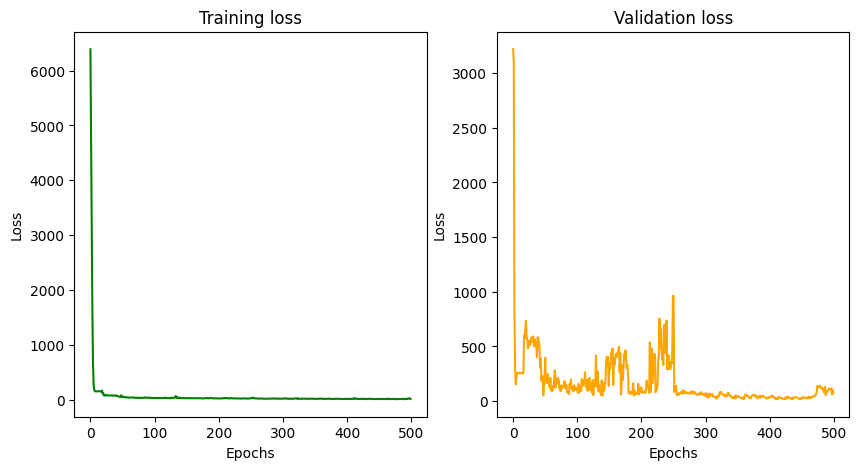

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.plot(train_loss, color='green')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.plot(val_loss, color='orange')

plt.show()

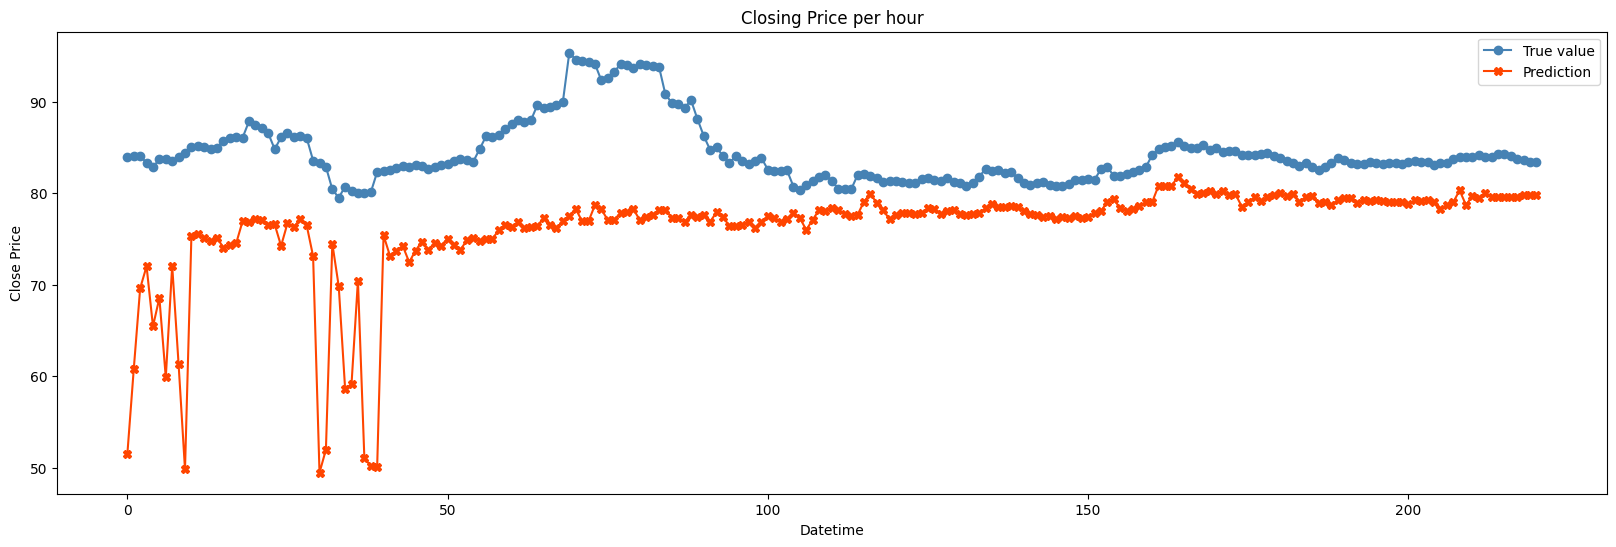

In [40]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test_1, model.predict(X_test_1, verbose=0))

## **8. Tổng kết**

**BẢNG SO SÁNH CHỈ SỐ HUẤN LUYỆN MÔ HÌNH**

|Model|MAE|MSE|RMSE|MAPE|
|-|-|-|-|-|
|XGBoost|3.3077|21.5294|4.6400|3.8579|
|Linear Regression|14.6631|255.2528|15.9766|17.3396|
|**Ridge Regression**|**2.2344**|**7.5599**|**2.7495**|**2.6304**|
|BiLSTM|8.1497|106.0548|10.2983|9.5605|

---

1. Xét về các chỉ số đo lường, mô hình **Linear Regression** và **BiLSTM** có giá trị của các chỉ số đánh giá không tốt. Kết quả biểu diễn lên biểu đồ cũng không thực sự trực quan, BiLSTM thì thể hiện được xu hướng của giá cổ phiểu ở các thời điểm gần tốt hơn, Linear Regression chưa thể hiện được xu hướng cổ phiếu.

2. Còn 2 mô hình XGBoost và Ridge Regression, thể hiện xu hướng của cổ phiếu tốt hơn.
* **Mô hình XGBoost** có thời gian huấn luyện ngắn, chỉ số đánh giá tương đối ổn và xu hướng cổ phiếu được biểu diễn rất tốt trên biểu đồ, đường dự đoán giá cổ phiếu có cùng hình dạng với đường giá cổ phiếu thực tế.
* **Mô hình Ridge Regression** tuy có các chỉ số đánh giá tốt nhưng lại chưa thể hiện xu hướng của biểu đồ tốt như của XGBoost.

Vì vậy, xét về độ chính xác trong sự biến động giá cổ phiếu, **mô hình XGBoost là tốt nhất** trong các mô hình khác được chọn ở dự án này.